# Лабораторная работа номер 6

## Задание 1

Исследовать влияние характеристик атрибутов программного проекта
(MODP, TOOL) на трудоемкость (РМ) и время разработки проекта
(ТМ) для базового уровня модели COCOMO и разных типов проектов
(обычного, встроенного, промежуточного). Для этого получить
значения PM и ТМ по всем типам проектов для одного и того же
значения параметра SIZE (размера программного кода) при изменении
значений атрибутов проекта от низких до высоких. Проанализировать
как повлияет на трудоемкость и время реализации проекта внесение
дополнительных ограничений на требуемые сроки разработки
(параметр SCED). Результаты исследований оформить графически и
сделать соответствующие выводы.

Трудозатраты = С1 * EAF * (Размер)^p1 (количество человеко-месяцев)

C1 - масштабируемый коэффициент
EAF - уточняющий фактор, хар-ий предметную область/персонал/среду/инструментарий,
используемый для создания рабочих продуктов процесса
Размер - размер конечного продукта (кода, созданного человеком)
p1 - показатель степени, хар-ий экономию при больших масштабах, присущую тому
процессу, который используется для создания конечного продукта;
в частности, способность процесса избегать непроизводительных видов
деятельности (доработок, бюрократических проволочек, накладных расходов)

Время = С2 * (Трудозатраты)^p2 (общее количество месяцев)

С2 - масштабирующий коэффициент для сроков исполнения
Р2 - показатель степени, характеризует инерцию и распараллеливание, присущие
управлению разработкой ПО

In [71]:
from typing import List, Dict, Tuple
from copy import deepcopy
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
import ipywidgets as widgets
from IPython.display import display

NUM_LEVELS = 5
SIZE = 100
xArr = ['низкий уровень', 'номинальный уровень', 'высокий уровень']

# Типы проектов
NORMAL = {'c1': 3.2, 'p1': 1.05, 'c2': 2.5, 'p2': 0.38}  # Обычный вариант - некрупный проект, нет нововведений, всё знакомо
INTER = {'c1': 3.0, 'p1': 1.12, 'c2': 2.5, 'p2': 0.35}  # Промежуточный вариант - средний проект, есть инновации
BUILDIN = {'c1': 2.8, 'p1': 1.2, 'c2': 2.5, 'p2': 0.32}  # Встроенный вариант - крупный проект, значительный объем инноваций

# Атрибуты программного продукта
RELY = [0.75, 0.86, 1.0, 1.15, 1.4]  # Требуемая надежность
DATA = [None, 0.94, 1.0, 1.08, 1.16]  # Размер БД
CPLX = [0.7, 0.85, 1.0, 1.15, 1.3]  # Сложность продукта

# Атрибуты копьютера
TIME = [None, None, 1.0, 1.11, 1.5]  # Ограничение времени выполнения
STOR = [None, None, 1.0, 1.06, 1.21]  # Ограничение объёма основной памяти
VIRT = [None, 0.87, 1.0, 1.15, 1.30]  # Изменчивость виртуальной машины
TURN = [None, 0.87, 1.0, 1.07, 1.15]  # Время реакции компьютера

# Атрибуты персонала
ACAP = [1.46, 1.19, 1.0, 0.86, 0.71]  # Способности аналитика
AEXP = [1.29, 1.15, 1.0, 0.91, 0.82]  # Знание приложений
PCAP = [1.42, 1.17, 1.0, 0.86, 0.7]   # Способности программиста
VEXP = [1.21, 1.1, 1.0, 0.9, None]    # Знание виртуальной машины
LEXP = [1.14, 1.07, 1.0, 0.95, None]  # Знание ЯП

# Атрибуты проекта
MODP = [1.24, 1.1, 1.0, 0.91, 0.82]  # Использование современных методов
TOOL = [1.24, 1.1, 1.0, 0.91, 0.82]  # Использование программных инструментов
SCED = [1.23, 1.08, 1.0, 1.04, 1.1]  # Требуемые сроки разработки
DEFAULT = {
    'RELY': RELY[2],
    'DATA': DATA[2],
    'CPLX': CPLX[2],
    'TIME': TIME[2],
    'STOR': STOR[2],
    'VIRT': VIRT[2],
    'TURN': TURN[2],
    'ACAP': ACAP[2],
    'AEXP': AEXP[2],
    'PCAP': PCAP[2],
    'VEXP': VEXP[2],
    'LEXP': LEXP[2],
    'MODP': MODP[2],
    'TOOL': TOOL[2],
    'SCED': SCED[2],
}

project_modes = {
    'c1': [3.2, 3.0, 2.8],
    'p1': [1.05, 1.12, 1.2],
    'c2': [2.5, 2.5, 2.5],
    'p2': [0.38, 0.35, 0.32]
}

PM = lambda c1, p1, EAF, SIZE: c1 * EAF * (SIZE ** p1)

TM = lambda c2, p2, PM: c2 * (PM ** p2)

EAF = lambda params: np.prod(params)

params_table = {
    'RELY': [0.75, 0.86, 1.0, 1.15, 1.40],
    'DATA': [None, 0.94, 1.0, 1.08, 1.16],
    'CPLX': [0.70, 0.85, 1.0, 1.15, 1.30],
    'TIME': [None, None, 1.0, 1.11, 1.50],
    'STOR': [None, None, 1.0, 1.06, 1.21],
    'VIRT': [None, 0.87, 1.0, 1.15, 1.30],
    'TURN': [None, 0.87, 1.0, 1.07, 1.15],
    'ACAP': [1.46, 1.19, 1.0, 0.86, 0.71],
    'AEXP': [1.29, 1.15, 1.0, 0.91, 0.82],
    'PCAP': [1.42, 1.17, 1.0, 0.86, 0.70],
    'VEXP': [1.21, 1.10, 1.0, 0.90, None],
    'LEXP': [1.14, 1.07, 1.0, 0.95, None],
    'MODP': [1.24, 1.10, 1.0, 0.91, 0.82],
    'TOOL': [1.24, 1.10, 1.0, 0.91, 0.82],
    'SCED': [1.23, 1.08, 1.0, 1.04, 1.10],
}

wbf_budget = np.array([4, 12, 44, 6, 14, 7, 7, 6, 100])

classic_coeffs = np.array([
    [0.08, 0.18, 0.25, 0.26, 0.31, 1.0],
    [0.36, 0.36, 0.18, 0.18, 0.28, 1.0],
])

In [74]:
levels = ['Очень низкий', 'Низкий', 'Номинальный', 'Высокий', 'Очень высокий']

nominal=1

# project_types = ['Обычный', 'Промежуточный', 'Встроенный']

wds_names = [
    'Анализ требований',
    'Проектирование продукта',
    'Программирование',
    'Планирование тестирования',
    'Верификация и аттестация',
    'Канцелярия проекта',
    'Управление конфигурацией и обеспечение качества',
    'Создание руководств',
    'ИТОГО',
]

classic_names = [
    'Планирование и определение требований',
    'Проектирование продукта',
    'Детальное проектирование',
    'Кодирование и тестирование отдельных модулей',
    'Интеграция и тестирование',
    'Итого без планирования',
    'ИТОГО',
]

project_types = {
    'Обычный': {'c1': 3.2, 'p1': 1.05, 'c2': 2.5, 'p2': 0.38},  # Обычный вариант - некрупный проект, нет нововведений, всё знакомо
    'Промежуточный': {'c1': 3.0, 'p1': 1.12, 'c2': 2.5, 'p2': 0.35},  # Промежуточный вариант - средний проект, есть инновации
    'Встроенный': {'c1': 2.8, 'p1': 1.2, 'c2': 2.5, 'p2': 0.32}  # Встроенный вариант - крупный проект, значительный объем инноваций
}

In [75]:
params_dict = {
    name: widgets.Dropdown(
        options=[
            (l, v) for l, v in zip(levels, values) if v is not None
        ],
        value=nominal,
        description=name,
        disabled=False,
    )
    for (name, values) in params_table.items()
}

project_type = widgets.Dropdown(
    options=[
        (t, i) for i, t in enumerate(project_types)
    ],
    description='Тип проекта',
    disabled=False,
)

project_size = widgets.BoundedIntText(
    value=100,
    min=0,
    max=10000,
    step=1,
    description='SIZE (KLOC):'
)

view2 = [
    widgets.Label('Информация о проекте'),
    widgets.GridBox(
        children=[project_type, project_size],
        layout=widgets.Layout(grid_template_columns='auto auto')
    ),
    widgets.Label('Информация о ресурсах'),
    widgets.GridBox(
        children=list(params_dict.values()),
        layout=widgets.Layout(grid_template_columns='auto auto')
    ),
]

size = 55.0
salary = 62000

widgets.VBox(view2)

In [48]:
def getEAF(params: Dict[str, float]) -> float:
    mult = 1
    for elem in params.values():
        mult *= elem

    return mult


def getLaborCosts(c1: float, eaf: float, size: float, p1: float) -> float:
    return c1 * eaf * size ** p1


def getTime(c2: float, laborCosts: float, p2:float) -> float:
    return c2 * laborCosts ** p2


def calculate(params: Dict[str, float], variant: Dict[str, float], size: float) -> Tuple[float, float]:
    eaf = getEAF(params)
    laborCosts = getLaborCosts(variant['c1'], eaf, size, variant['p1'])
    time = getTime(variant['c2'], laborCosts, variant['p2'])

    return laborCosts, time


def process(variant: Dict[str, float], key: str, value: float, size: int):
    params = deepcopy(params_table)
    params[key] = value

    return calculate(params, variant, size)


def process_2(variant: Dict[str, float], size: int):
    params = deepcopy(params_table)

    return calculate(params, variant, size)


def runExperiment(params: Dict[str, float], variant: Dict[str, float], size: float, salary: int):
    res = {}
    res['laborCosts'], res['time'] = calculate(params, variant, size)

    res['planWork'] = res['laborCosts'] * 1.08
    res['planTime'] = res['time'] * 1.36

    res['planWorkSingle'] = res['laborCosts'] * 0.08
    res['planTimeSingle'] = res['time'] * 0.36
    res['planPeople'] = math.ceil(res['planWorkSingle'] / res['planTimeSingle'])

    res['designWork'] = res['laborCosts'] * 0.18
    res['designTime'] = res['time'] * 0.36
    res['designPeople'] = math.ceil(res['designWork'] / res['designTime'])

    res['detailWork'] = res['laborCosts'] * 0.25
    res['detailTime'] = res['time'] * 0.18
    res['detailPeople'] = math.ceil(res['detailWork'] / res['detailTime'])

    res['codingWork'] = res['laborCosts'] * 0.26
    res['codingTime'] = res['time'] * 0.18
    res['codingPeople'] = math.ceil(res['codingWork'] / res['codingTime'])

    res['integWork'] = res['laborCosts'] * 0.31
    res['integTime'] = res['time'] * 0.28
    res['integPeople'] = math.ceil(res['integWork'] / res['integTime'])

    res['analysis'] = 4
    res['anPeople'] = res['laborCosts'] * 0.04

    res['design'] = 12
    res['dePeople'] = res['laborCosts'] * 0.12

    res['coding'] = 44
    res['coPeople'] = res['laborCosts'] * 0.44

    res['planning'] = 6
    res['plPeople'] = res['laborCosts'] * 0.06

    res['ver'] = 14
    res['verPeople'] = res['laborCosts'] * 0.14

    res['office'] = 7
    res['ofPeople'] = res['laborCosts'] * 0.07

    res['quality'] = 7
    res['quPeople'] = res['laborCosts'] * 0.07

    res['manuals'] = 6
    res['maPeople'] = res['laborCosts'] * 0.06

    res['budget'] = res['laborCosts'] * salary

    salary = {
        "Programmer": salary,
        "Analytic": salary * 1.4,
        "Manager": salary * 1.3,
        "Tester": salary * 0.65,
    }

    budget = []
    budget += [(((salary['Manager'] + salary['Analytic']) / 2) * res['designPeople'] * res['planTimeSingle'])]
    budget += [(((salary['Programmer'] + salary['Analytic']) / 2) * res['designPeople'] * res['designTime'])]
    budget += [(((salary['Programmer'] + salary['Analytic']) / 2) * res['detailPeople'] * res['detailTime'])]
    budget += [(((salary['Programmer'] + salary['Tester']) / 2) * res['codingPeople'] * res['codingTime'])]
    budget += [(((salary['Programmer'] + salary['Tester']) / 2) * res['integPeople'] * res['integTime'])]

    s = 0
    for i in range(len(budget)):
        s += budget[i]

    allTimeInfo = [res['planTimeSingle'], res['designTime'],
                   res['detailTime'], res['codingTime'],
                   res['integTime']]
    allPeopleInfo = [res['planPeople'], res['designPeople'],
                     res['detailPeople'], res['codingPeople'],
                     res['integPeople']]

    xData, yData = [], []

    s = 0
    for i in range(len(allTimeInfo)):
        time = s
        while time < s + allTimeInfo[i]:
            xData.append(time)
            yData.append(allPeopleInfo[i])
            time += 1
        s += allTimeInfo[i]

    plt.title('Сотрудники')
    plt.grid(True)
    plt.bar(xData, yData)
    plt.xlabel("Месяцы")
    plt.ylabel("Количество сотрудников")
    plt.show()

    return res

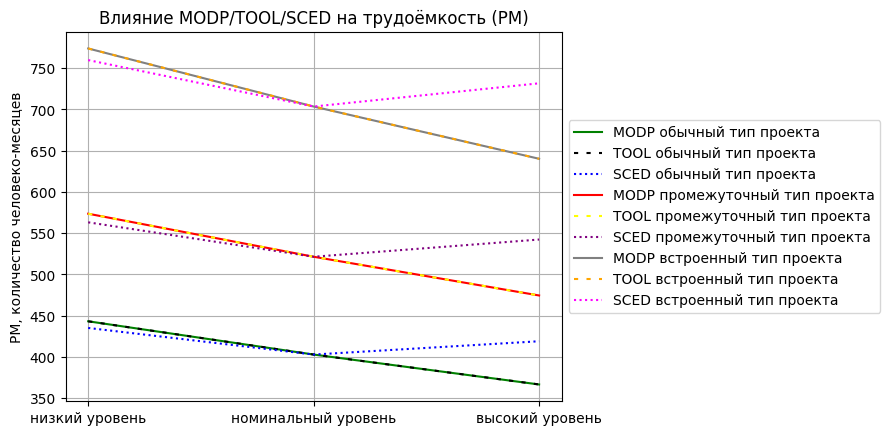

In [49]:
def draw(laborMODP, laborTOOL, laborSCED, timeMODP, timeTOOL, timeSCED):
    _, axs = plt.subplots()
    colorArr = [['green', 'black', 'blue'], ['red', 'yellow', 'purple'], ['grey', 'orange', 'fuchsia']]
    typeArr = ['обычный тип проекта', 'промежуточный тип проекта', 'встроенный тип проекта']
    axs.set_title('Влияние MODP/TOOL/SCED на трудоёмкость (РМ)')
    axs.set(ylabel="PM, количество человеко-месяцев")
    axs.grid()

    for i in range(len(laborMODP)):
        axs.plot(xArr, laborMODP[i], label='MODP ' + typeArr[i], color=colorArr[i][0])
        axs.plot(xArr, laborTOOL[i], label='TOOL ' + typeArr[i], linestyle='--', color=colorArr[i][1], dashes=(2, 4))
        axs.plot(xArr, laborSCED[i], label='SCED ' + typeArr[i], linestyle=':', color=colorArr[i][2])

    axs.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()



laborMODP, laborTOOL, laborSCED = [], [], []
timeMODP, timeTOOL, timeSCED = [], [], []

for variant in [NORMAL, INTER, BUILDIN]:
    laborMODPArr, laborTOOLArr, laborSCEDArr = [], [], []
    timeMODPArr, timeTOOLArr, timeSCEDArr = [], [], []

    for level in range(1, NUM_LEVELS - 1):
        laborCosts, time = process(variant, 'MODP', MODP[level], SIZE)
        laborMODPArr.append(laborCosts)
        timeMODPArr.append(time)

        laborCosts, time = process(variant, 'TOOL', TOOL[level], SIZE)
        laborTOOLArr.append(laborCosts)
        timeTOOLArr.append(time)

        laborCosts, time = process(variant, 'SCED', SCED[level], SIZE)
        laborSCEDArr.append(laborCosts)
        timeSCEDArr.append(time)

    laborMODP.append(laborMODPArr)
    laborTOOL.append(laborTOOLArr)
    laborSCED.append(laborSCEDArr)

    timeMODP.append(timeMODPArr)
    timeTOOL.append(timeTOOLArr)
    timeSCED.append(timeSCEDArr)

draw(laborMODP, laborTOOL, laborSCED, timeMODP, timeTOOL, timeSCED)

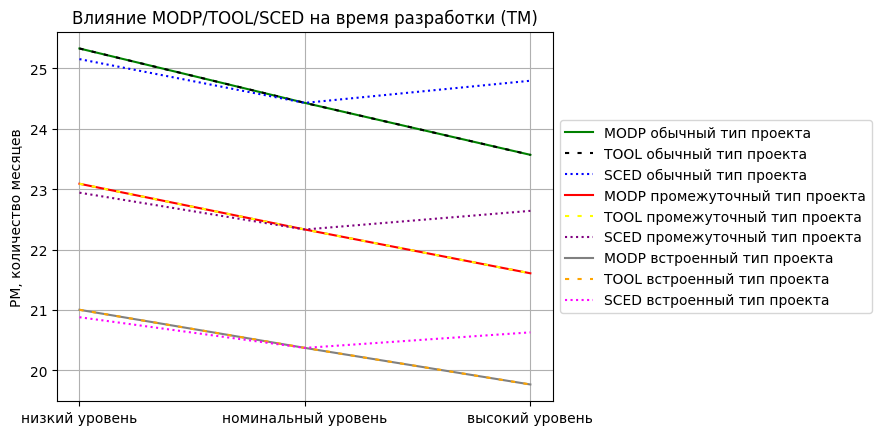

In [50]:
def draw2(laborMODP, timeMODP, timeTOOL, timeSCED):
    _, axs = plt.subplots()
    colorArr = [['green', 'black', 'blue'], ['red', 'yellow', 'purple'], ['grey', 'orange', 'fuchsia']]
    typeArr = ['обычный тип проекта', 'промежуточный тип проекта', 'встроенный тип проекта']

    axs.set_title("Влияние MODP/TOOL/SCED на время разработки (TМ)")
    axs.set(ylabel="PM, количество месяцев")
    axs.grid()

    for i in range(len(laborMODP)):

        axs.plot(xArr, timeMODP[i], label='MODP ' + typeArr[i], color=colorArr[i][0])
        axs.plot(xArr, timeTOOL[i], label='TOOL ' + typeArr[i], linestyle='--', color=colorArr[i][1], dashes=(2, 4))
        axs.plot(xArr, timeSCED[i], label='SCED ' + typeArr[i], linestyle=':', color=colorArr[i][2])

    axs.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

draw2(laborMODP, timeMODP, timeTOOL, timeSCED)

## Задание 2

In [51]:
import pprint

TASK2 = {
    'RELY': RELY[2],
    'DATA': DATA[3],
    'CPLX': CPLX[2],
    'TIME': TIME[2],
    'STOR': STOR[2],
    'VIRT': VIRT[2],
    'TURN': TURN[2],
    'ACAP': ACAP[3],
    'AEXP': AEXP[2],
    'PCAP': PCAP[2],
    'VEXP': VEXP[2],
    'LEXP': LEXP[2],
    'MODP': MODP[2],
    'TOOL': TOOL[2],
    'SCED': SCED[2],
}

params = deepcopy(TASK2)

variant = INTER
pprint.pp(params)

{'RELY': 1.0,
 'DATA': 1.08,
 'CPLX': 1.0,
 'TIME': 1.0,
 'STOR': 1.0,
 'VIRT': 1.0,
 'TURN': 1.0,
 'ACAP': 0.86,
 'AEXP': 1.0,
 'PCAP': 1.0,
 'VEXP': 1.0,
 'LEXP': 1.0,
 'MODP': 1.0,
 'TOOL': 1.0,
 'SCED': 1.0}


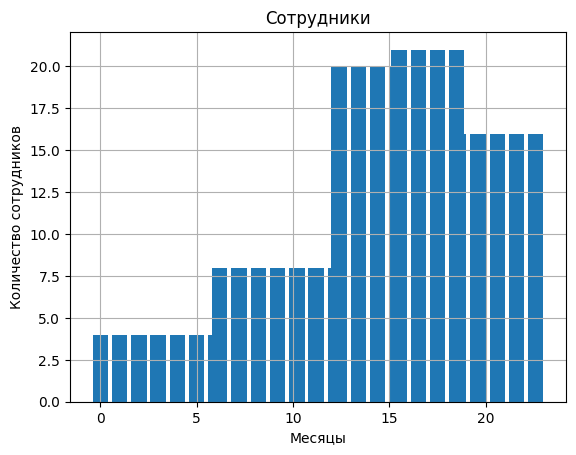

In [52]:
res = runExperiment(params, variant, size, salary)


In [53]:
print(f" Без планирования. Трудозатараты: {res['laborCosts']:.3f}, Время: {res['time']:.3f}")
print(f" C планированием. Трудозатараты: {res['planWork']:.3f}, Время: {res['planTime']:.3f}")

 Без планирования. Трудозатараты: 247.885, Время: 17.216
 C планированием. Трудозатараты: 267.715, Время: 23.413


In [54]:
print(f" Планирование и определение времени. \n Трудозатараты: {res['planWorkSingle']:.3f}, Время: {res['planTimeSingle']:.3f}, Сотрудники: {res['planPeople']:.0f} \n\n")

print(f" Проектирование продукта. \n Трудозатараты: {res['designWork']:.3f}, Время: {res['designTime']:.3f}, Сотрудники: {res['designPeople']:.0f}\n\n")

print(f" Детальное проектирование. \n Трудозатараты: {res['detailWork']:.3f}, Время: {res['detailTime']:.3f}, Сотрудники: {res['detailPeople']:.0f}\n\n")

print(f" Кодирование и Тестирование отдельных модулей. \n Трудозатараты: {res['codingWork']:.3f}, Время: {res['codingTime']:.3f}, Сотрудники: {res['codingPeople']:.0f}\n\n")

print(f" Интеграция и тестирование. \n Трудозатараты: {res['integWork']:.3f}, Время: {res['integTime']:.3f}, Сотрудники: {res['integPeople']:.0f}")


 Планирование и определение времени. 
 Трудозатараты: 19.831, Время: 6.198, Сотрудники: 4 


 Проектирование продукта. 
 Трудозатараты: 44.619, Время: 6.198, Сотрудники: 8


 Детальное проектирование. 
 Трудозатараты: 61.971, Время: 3.099, Сотрудники: 20


 Кодирование и Тестирование отдельных модулей. 
 Трудозатараты: 64.450, Время: 3.099, Сотрудники: 21


 Интеграция и тестирование. 
 Трудозатараты: 76.844, Время: 4.820, Сотрудники: 16


In [55]:
print(f" Анализ требований \n Бюджет (%): {res['analysis']:.0f}, Трудозатраты: {res['anPeople']:.3f}\n")

print(f" Проектирование продукта \n Бюджет (%): {res['design']:.0f}, Трудозатраты: {res['dePeople']:.3f}\n")

print(f" Программирование \n Бюджет (%): {res['coding']:.0f}, Трудозатраты: {res['coPeople']:.3f}\n")

print(f" Планирование тестирования \n Бюджет (%): {res['planning']:.0f}, Трудозатраты: {res['plPeople']:.3f}\n")


print(f" Верификация и аттестация \n Бюджет (%): {res['ver']:.0f}, Трудозатраты: {res['verPeople']:.3f}\n")

print(f" Канцелярия проекта \n Бюджет (%): {res['office']:.0f}, Трудозатраты: {res['ofPeople']:.3f}\n")

print(f" Управление конфигурацией и обеспечение качества \n Бюджет (%): {res['quality']:.0f}, Трудозатраты: {res['quPeople']:.3f}\n")

print(f" Создание руководства \n Бюджет (%): {res['manuals']:.0f}, Трудозатраты: {res['maPeople']:.3f}\n")

 Анализ требований 
 Бюджет (%): 4, Трудозатраты: 9.915

 Проектирование продукта 
 Бюджет (%): 12, Трудозатраты: 29.746

 Программирование 
 Бюджет (%): 44, Трудозатраты: 109.069

 Планирование тестирования 
 Бюджет (%): 6, Трудозатраты: 14.873

 Верификация и аттестация 
 Бюджет (%): 14, Трудозатраты: 34.704

 Канцелярия проекта 
 Бюджет (%): 7, Трудозатраты: 17.352

 Управление конфигурацией и обеспечение качества 
 Бюджет (%): 7, Трудозатраты: 17.352

 Создание руководства 
 Бюджет (%): 6, Трудозатраты: 14.873



In [56]:
print(f"Бюджет: {res['budget']}")

Бюджет: 15368849.69142016
